In [1]:
from utils.generative_models import *

In [23]:
def xcorr_data(d1, d2, maxlags=None, normed=True):
    # IS united tested: returns the same thing as plt.xcorr!
    # Alternative from LIGO analysis
    d1 = np.asarray(d1)
    d2 = np.asarray(d2)
    N = len(d1)

    if maxlags is None:
        maxlags = N - 1

    lags = np.arange(-maxlags, maxlags + 1)
    c = np.correlate(d1 - np.mean(d1), d2 - np.mean(d2), mode='full')

    if normed:
        scale = np.std(d1) * np.std(d2) * N
        c = c / scale

    mid = len(c) // 2
    start = mid - maxlags
    stop = mid + maxlags + 1
    delays = lags / f
    return delays, c[start:stop]


def cross_correlate(d_1:np.array, d_2:np.array, t_1:np.array, t_2:np.array):
    if not np.all(t_1 == t_2):
        raise ValueError("The two time arrays must be the same.")
    t = t_1

    d_1 = d_1 - np.mean(d_1)
    d_2 = d_2 - np.mean(d_2)

    assert len(d_1) == len(d_2), "The two data arrays must have the same length."

    n = len(d_1)
    l = np.linspace(-(n-1), (n-1), 2*(n-1)+1)
    f = 1/(t[1]-t[0])
    taus = l/f

    # loop for all l's:

    correlations = []
    for l_star in l:
        l_star = int(l_star)
        # loop for a single l_star:
        summands = []
        for i in range(int(n-np.abs(l_star))):  # upper limit: n-l-1
            summands.append(d_1[i] * d_2[i+l_star])

        # normalization = n-np.abs(l_star)  # mathematically correct
        normalization = n  # suppresses regions of large delays, which we are not interested in because there cant be physically sourced correlations
        # after dividing with the noise power spectrum estimate that are on the order of ~10ms! These would be random noise correlations ... I think
        res_for_l_star = sum(summands) / normalization
        correlations.append(res_for_l_star)

    correlations = np.array(correlations)/(np.std(d_1)*np.std(d_2))   # normalize with the standard deviations if wished
    return taus, correlations  # return time delays and C(τ)


def divisor(t: np.array, x: np.array, window_length: float):
    """
    Subdivides a given (x, t) time series into non-overlapping windows of duration `window_length` (in seconds).
    Assumes t is sorted and uniformly sampled.

    :param x:               The time series values.
    :param t:               The time stamps (1D array, same length as x).
    :param window_length:   Window length in seconds.
    :return:                Tuple of (windows of t, windows of x), both shaped (num_windows, samples_per_window)
    """
    dt = t[1] - t[0]  # assume uniform sampling
    samples_per_window = int(window_length / dt)

    total_samples = len(t)
    usable_samples = (total_samples // samples_per_window) * samples_per_window

    x = x[:usable_samples]
    t = t[:usable_samples]

    res_x = x.reshape(-1, samples_per_window)
    res_t = t.reshape(-1, samples_per_window)

    return res_t, res_x


In [13]:
strain_object_L1 = unpickle_me_this("../germany/data/GW150914_strain_L1.pickle")
strain_object_H1 = strain

whiten_and_bp = True
if whiten_and_bp:
    strain_object_L1 = strain_object_L1.whiten()#.bandpass(30, 400)
    strain_object_H1 = strain_object_H1.whiten()#.bandpass(30, 400)

    strain_H1 = strain_object_H1.value
    strain_L1 = strain_object_L1.value
else:
    strain_H1 = strain_object_H1.value * 1e19
    strain_L1 = strain_object_L1.value * 1e19

time_H1 = np.array(strain_object_H1.times) - zero_time
time_L1 = np.array(strain_object_L1.times) - zero_time


wl = 0.5 # seconds

div_object_l1 = divisor(time_L1, strain_L1, window_length=wl)
div_object_h1 = divisor(time_H1, strain_H1, window_length=wl)

time_windows_l1 = div_object_l1[0]
strain_windows_l1 = div_object_l1[1]

time_windows_h1 = div_object_h1[0]
strain_windows_h1 = div_object_h1[1]

f = 1/(time_H1[1] - time_H1[0])  # assuming time_H1 == time_L1 and both contain equidistantly spaced samples

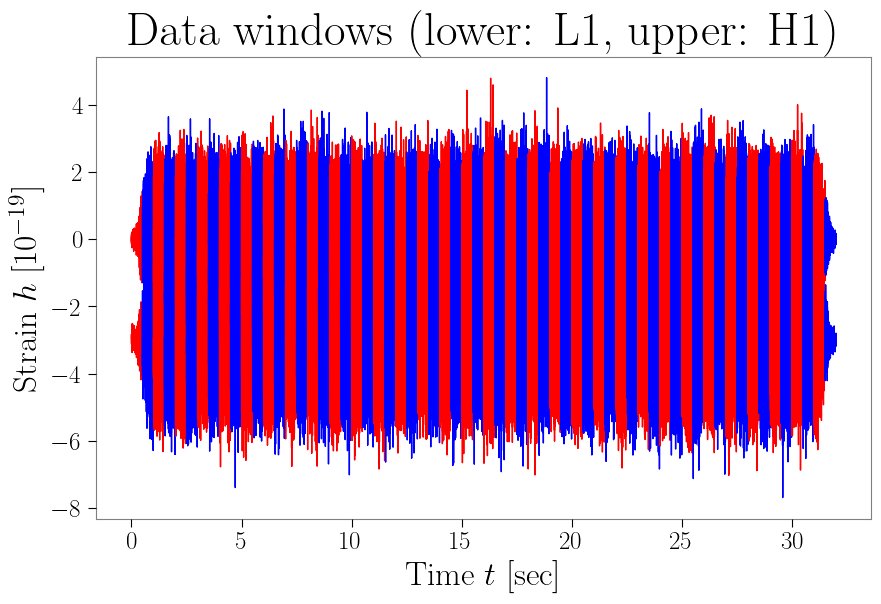

In [14]:
for idx in range(len(time_windows_h1)):
    if idx % 2 == 0:
        color = "red"
    else:
        color="blue"
    if whiten_and_bp:
        shift = -3
    else:
        shift = 0
    plt.plot(time_windows_h1[idx], strain_windows_h1[idx], color=color)
    plt.plot(time_windows_l1[idx], strain_windows_l1[idx]+shift, color=color)

usual_plot(title="Data windows (lower: L1, upper: H1)")

In [5]:
to_test = 38
example_delay, example_corr = cross_correlate(d_1=strain_windows_h1[to_test], d_2=strain_windows_l1[to_test], t_1=time_windows_h1[to_test], t_2=time_windows_l1[to_test])

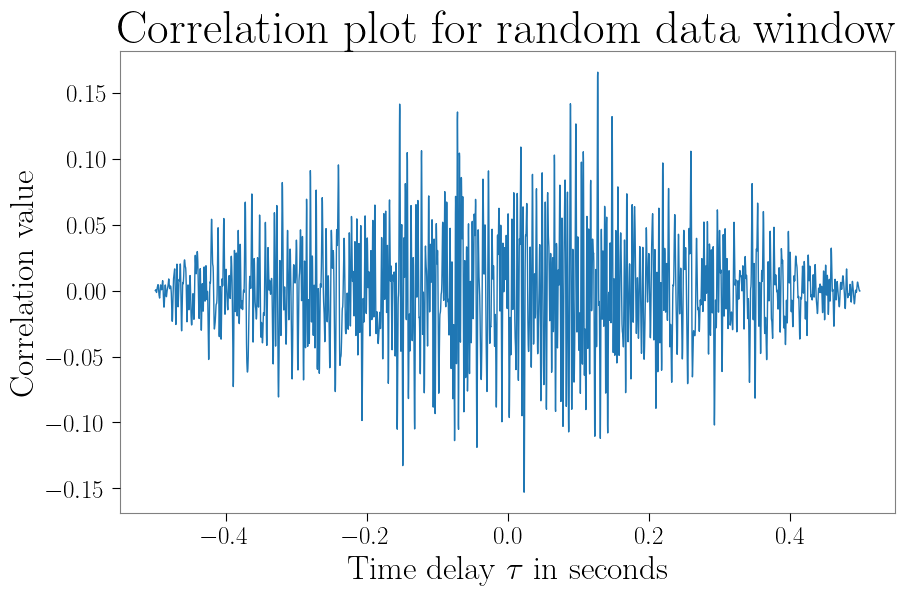

In [6]:
plt.plot(example_delay, example_corr)
usual_plot(xl=r"Time delay $\tau$ in seconds", yl="Correlation value", title="Correlation plot for random data window")

In [7]:
idx_of_window_of_interest = 32  # if window-length = 0.5
# plt.plot(time_windows_h1[idx_of_window_of_interest], strain_windows_h1[idx_of_window_of_interest], color="red")
# plt.plot(time_windows_h1[idx_of_window_of_interest], strain_windows_l1[idx_of_window_of_interest], color="blue")
# usual_plot()

In [8]:
delays, corr = cross_correlate(strain_windows_l1[idx_of_window_of_interest], strain_windows_h1[idx_of_window_of_interest], t_1=time_windows_h1[idx_of_window_of_interest], t_2=time_windows_l1[idx_of_window_of_interest])

In [9]:
delays_LIGO, corr_LIGO = xcorr_data(strain_windows_h1[idx_of_window_of_interest], strain_windows_l1[idx_of_window_of_interest])

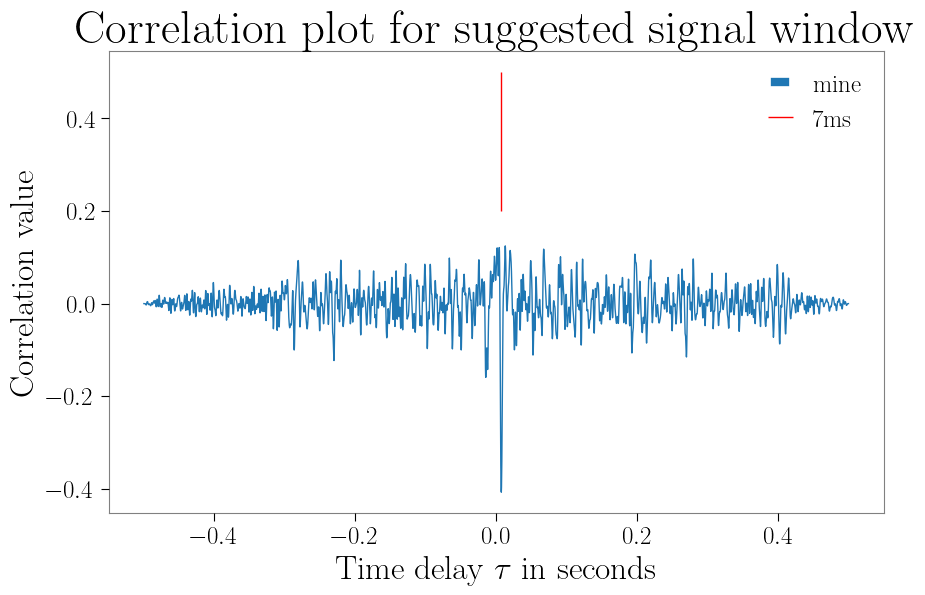

In [10]:
plt.plot(delays, corr, label="mine")
# plt.plot(delays_LIGO, corr_LIGO, label="ligo")
plt.vlines(7e-3 , 0.2, 0.5, label=r"$7\mathrm{ms}$", color="red")
plt.legend()
# plt.xlim(-0.05, 0.05)
usual_plot(xl=r"Time delay $\tau$ in seconds", yl="Correlation value", title="Correlation plot for suggested signal window")

In [24]:
all_correlation_tuples = []
for idx in range(len(time_windows_h1)):
    tmp = cross_correlate(d_1=strain_windows_h1[idx], d_2=strain_windows_l1[idx], t_1=time_windows_h1[idx], t_2=time_windows_l1[idx])
    # tmp = xcorr_data(strain_windows_h1[idx], strain_windows_l1[idx])
    all_correlation_tuples.append(tmp)

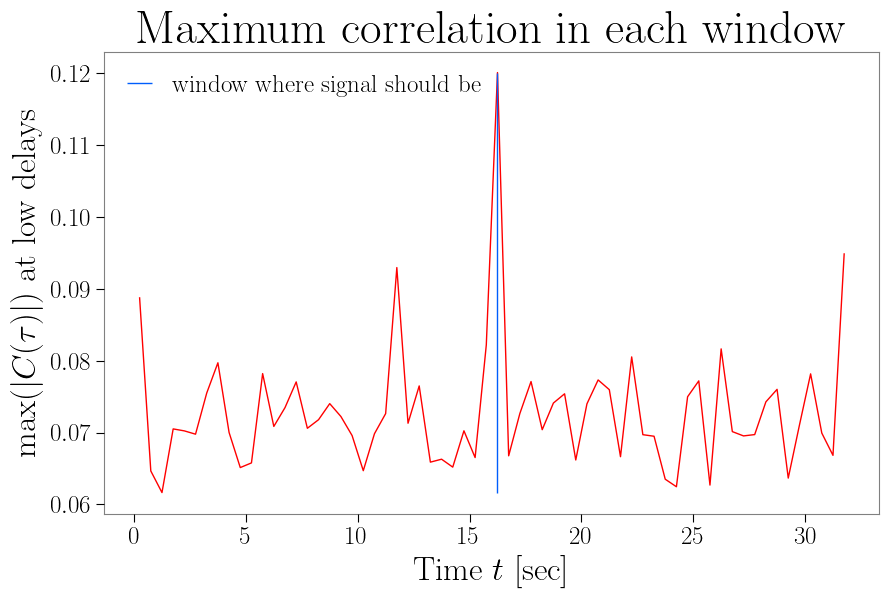

In [26]:
correlation_maxima = []
for result in all_correlation_tuples:
    delay, corr = result
    max_corr = np.max(np.abs(corr))
    correlation_maxima.append(max_corr)

middle_of_windows = [np.mean(el) for el in time_windows_h1]
plt.plot(middle_of_windows, correlation_maxima, color="red")
plt.vlines(16.25, min(correlation_maxima), max(correlation_maxima), color=blue, label="window where signal should be")
usual_plot(yl=r"$\mathrm{max}(|C(\tau)|)$ at low delays", title="Maximum correlation in each window")